# Classical PDE Solver Methods for Panel Buckling PDEs

Find the function w(x,y) and the eigenvalue $\lambda$ for transverse displacement of a plate such that on $\Omega = \{ (x,y) : 0 \leq x \leq a, \ 0 \leq y \leq b \}$ the PDE is satisfied. The constants $N_{xx}, N_{xy}, N_{yy}$ are prescribed by the user by loading type.
$$ D \nabla^4 w + \lambda ( N_{xx} \frac{\partial^2 w}{\partial x^2} + 2 N_{xy} \frac{\partial^2 w}{\partial x \partial y} + N_{yy} \frac{\partial^2 w}{\partial y^2} ) = 0 $$
And on the boundary $\partial \Omega$ we have simply supported BCs $w = 0$.

We will then use finite elements to solve this problem. First, we need to write the weak form with the test function $\delta w(x,y)$ in order to find a more suitable form for integration.
 
## Term 1 of the Weak Form
Term 1 of the weak form integral is:
$$ \int D \nabla^4 w \cdot \delta w dA = \int D (\frac{\partial^4 w}{\partial x^4} + 2 \frac{\partial^4 w}{\partial x^2 \partial y^2} + \frac{\partial^4 w}{\partial y^4} ) \cdot \delta w dA$$

The full expansion of this term is for each case:
$$ \int \frac{\partial^4 w}{\partial x^4} \cdot \delta w dx = (\frac{\partial^3 w}{\partial x^3} \delta w)|_{\partial \Omega} - (\frac{\partial^2 w}{\partial x^2} \frac{\partial \delta w}{\partial x})|_{\partial \Omega} + \int \frac{\partial^2 w}{\partial x^2} \frac{\partial^2 \delta w}{\partial x^2} dx $$
Since we have $w = 0$ on the boundary for simply supported and no moments on free edges for simply supported edges, the boundary terms are zero. WLOG, we can show that the full integral of term 1 of the weak form is:
$$ \int D \nabla^4 w \cdot \delta w dA = \int D \nabla^2 w \nabla^2 \delta w dA $$

## Term 2 of the Weak Form
The second term of the weak form involves user-prescribed constants $N_{ij}$ the in-plane loads and then we have:
$$ \int \left[ N_{xx} \frac{\partial^2 w}{\partial x^2} + 2 N_{xy} \frac{\partial^2 w}{\partial x \partial y} + N_{yy} \frac{\partial^2 w}{\partial y^2} \right] \delta w dA$$
By a similar argument, the boundary terms after integrating by parts are all zero as $\delta w = 0$ on the boundary. Then we have:
$$ - \int \left[ N_{xx} \frac{\partial w}{\partial x} \frac{\partial \delta w}{\partial x} + N_{xy} (\frac{\partial w}{\partial x} \frac{\partial \delta w}{\partial y} + \frac{\partial w}{\partial y} \frac{\partial \delta w}{\partial x}) + N_{yy} \frac{\partial w}{\partial y} \frac{\partial \delta w}{\partial y} \right] dA $$

## Finite Element Matrix
### Basis functions
Was originally using a quadratic element with 9-nodes and 2x2 Gauss quadrature. However, that gave really poor buckling mode estimates as it doesn't result in zero moments at the ends of the plate. I need to use higher-order elements like hermite cubic element (what we do for beams) in order to ensure zero moments at the end of the plate for the simply supported boundary condition. Otherwise I would have to use a penalty method to enforce zero moment constraint. I also need to use a 3x3 or 4x4 Gauss quadrature rule here.


Then we need to compute the integrals on a single element:
$$ K_{ij} = \int D \nabla^2 \phi_i \nabla^2 \phi_j dA $$

And the stability matrix $G_{ij}$ below whose shear term is symmetric!
$$ G_{ij} = \int N_{xx} \partial_{x} \phi_i \partial_{x} \phi_j + N_{xy} \cdot (\partial_x \phi_i \partial_y \phi_j + \partial_y \phi_i \cdot \partial_x \phi_j) + N_{yy} \partial_{y} \phi_i \partial_{y} \phi_j dA $$

## Gaussian Quadrature
The integral of an arbitrary 2D function $f(x,y)$ over a quadrilateral can be approximated as:
$$ \int f(x,y) dx dy \approx \sum_{q \in Q} w_q f(x_q, y_q) $$
Where the Gauss quadrature rule for 4 quadrature points on a quadrilateral is:
$$ w_q = \{ 1, 1, 1, 1 \} $$
And the quadrature points are:
$$ (x_q, y_q) = (\pm 1/\sqrt{3}, \pm 1/\sqrt{3}) $$

## Compute Element Stiffness and Stability Matrices
Convert the derivatives to isoperimetric space or computational coordinate space $\xi = 2 (x - x_c) / \Delta x, \eta = 2( y - y_c) / \Delta y$ so that $\xi \in [-1, 1]$ on the element and $\eta \in [-1,1]$ on the element. The differentials conversion is then: $ dx = \Delta x / 2 \cdot d \xi$, $dy = \Delta y / 2 \cdot d \eta $.

In [ ]:
"""
This block shows how to compute element stiffness and stability matrices for FEM panel buckling.
This is basically a library of methods that we need to solve the FEM panel buckling problem in
the next code block.
"""

import numpy as np
# from scipy.linalg import eigh
from scipy.sparse.linalg import eigs

def quadrature_rule(iquad):
    # TODO : change this to 3x3 quadrature rule not 2x2
    # 4 quadrature points for quad element
    # return the [xi,eta] quad pt location and w the quadrature weight
    rt3 = 1.0/(3.0**0.5)
    if iquad == 0:
        return [rt3, rt3], 1.0
    elif iquad == 1:
        return [rt3, -rt3], 1.0
    elif iquad == 2:
        return [-rt3, rt3], 1.0
    elif iquad == 3:
        return [-rt3, -rt3], 1.0



def get_xi_polynomials(ibasis):
    # get xi_factors in polynomial-list form for each basis function
    if ibasis == 0: # nz point (0,0)
        return [1, -3, 2]
    elif ibasis == 1: # nz point (1/2,0)
        return [0, 4, -4]
    elif ibasis == 2: # nz point (1,0)
        return [0, -1, 2]
    elif ibasis == 3: # nz point (0,1/2)
        return [4, -12, 8]
    elif ibasis == 4: # nz point (1/2,1/2)
        return [0, 16, -16]
    elif ibasis == 5: # nz point (1, 1/2)
        return [0, -4, 8]
    elif ibasis == 6: # nz point (0,1)
        return [1, -3, 2]
    elif ibasis == 7: # nz point (1/2,1)
        return [0, 4, -4]
    elif ibasis == 8: # nz point (1,1)
        return [0, -1, 2]
    
def get_eta_polynomials(ibasis):
    # get eta_factors in polynomial-list form for each basis function
    if ibasis == 0: # nz point (0,0)
        return [1, -3, 2]
    elif ibasis == 1: # nz point (1/2,0)
        return [1, -3, 2]
    elif ibasis == 2: # nz point (1,0)
        return [1, -3, 2]
    elif ibasis == 3: # nz point (0,1/2)
        return [0, 1, -1]
    elif ibasis == 4: # nz point (1/2,1/2)
        return [0, 1, -1]
    elif ibasis == 5: # nz point (1, 1/2)
        return [0, 1, -1]
    elif ibasis == 6: # nz point (0,1)
        return [0, -1, 2]
    elif ibasis == 7: # nz point (1/2,1)
        return [0, -1, 2]
    elif ibasis == 8: # nz point (1,1)
        return [0, -1, 2]

def eval_polynomial(poly_list, value):
    poly_list_arr = np.array(poly_list)
    var_list_arr = np.array([value**(ind) for ind in range(len(poly_list))])
    return np.dot(poly_list_arr, var_list_arr)

def get_laplacian(ibasis, xi, eta, xscale, yscale):
    xi_poly = get_xi_polynomials(ibasis)
    eta_poly = get_eta_polynomials(ibasis)

    xi_factor = eval_polynomial(xi_poly, xi)
    eta_factor = eval_polynomial(eta_poly, eta)
    
    dphi_dxx = 1/xscale**2 * 2.0 * xi_poly[-1] * eta_factor
    dphi_dyy = 1/yscale**2 * 2.0 * eta_poly[-1] * xi_factor
    return dphi_dxx + dphi_dyy

def get_gradient(ibasis, xi, eta, xscale, yscale):
    # compute dphi/dx and dphi/dy for the gradient at a given xi, eta point in the isoperimetric element
    xi_poly = get_xi_polynomials(ibasis)
    eta_poly = get_eta_polynomials(ibasis)

    xi_factor = eval_polynomial(xi_poly, xi)
    eta_factor = eval_polynomial(eta_poly, eta)

    d1_xi_poly = [xi_poly[1], 2.0 * xi_poly[-1]]
    dphi_dx = 1.0/xscale * eval_polynomial(d1_xi_poly, xi) * eta_factor

    d1_eta_poly = [eta_poly[1], 2.0 * eta_poly[-1]]
    dphi_dy = 1.0 / yscale * eval_polynomial(d1_eta_poly, eta) * xi_factor

    return [dphi_dx, dphi_dy]

def get_kelem(D, xscale, yscale):
    """
    compute the element stiffness matrix for an element with given x and y dimensions.
    Normally xscale = dx/2 and yscale = dy/2 for jacobian conversion dX/dxi
    """

    # sum over each of the quadrature points and basis functions
    nquad = 4
    nbasis = 9
    Kelem = np.zeros((nbasis, nbasis))
    for iquad in range(nquad):
        pt, weight = quadrature_rule(iquad)
        xi = pt[0]
        eta = pt[1]
        for i in range(nbasis):
            for j in range(nbasis):
                Kelem[i,j] += D * weight * xscale * yscale * \
                get_laplacian(i, xi, eta, xscale, yscale) * \
                get_laplacian(j, xi, eta, xscale, yscale)

    # print(f"{Kelem=}")

    return Kelem

def get_gelem(Nxx, Nxy, Nyy, xscale, yscale):
    """
    compute the element stability matrix which is dependent on the in-plane loads
    """
    nquad = 4
    nbasis = 9
    Gelem = np.zeros((nbasis, nbasis))
    for iquad in range(nquad):
        pt, weight = quadrature_rule(iquad)
        xi = pt[0]
        eta = pt[1]
        for i in range(nbasis):
            for j in range(nbasis):
                grad_i = get_gradient(i, xi, eta, xscale, yscale)
                grad_j = get_gradient(j, xi, eta, xscale, yscale)
                Gelem[i,j] += weight * xscale * yscale * \
                 (Nxx * grad_i[0] * grad_j[0] + \
                  Nxy * grad_i[0] * grad_j[1] + Nxy * grad_i[1] * grad_j[0] + \
                  Nyy * grad_i[1] * grad_j[1])

    return Gelem

def solve_fem_buckling(D, a, b, Nxx, Nxy, Nyy, nxe, nye, sigma):
    """
    solve the finite element panel buckling problem for metal, simply supported plate with a,b panel
    length and width respectively. The D bending stiffness material only affects scale of eigenvalue.
    """

    # generate a structured mesh of a flat plate in xy-plane
    # with panel length a (x-direction) and panel width b (y-direction)
    
    # node counts in each direction
    nnx = nxe + 1 + nxe
    nny = nye + 1 + nye
    num_nodes = nnx * nny
    nodes = [_ for _ in range(num_nodes)]

    # since rect elements the xscale, yscale is fixed and can compute here
    xscale = a / nxe
    yscale = b / nye

    # and we can also pre-compute the Kelem and Gelem (same for every element)
    Kelem = get_kelem(D, xscale, yscale)
    Gelem = get_gelem(Nxx, Nxy, Nyy, xscale, yscale)
    

    # connectivity is x-dir first then y-dir
    # here we make the geometry nodes the same as the 
    conn = []
    num_elements = nxe * nye
    for iy in range(nye):
        for ix in range(nxe):
            istart = ix * 2 + 2 * nnx * iy
            istart2 = istart + nnx
            istart3 = istart2 + nnx

            # 9 nodes in each element (same order as basis functions)
            conn += [[
                istart, istart+1, istart+2,
                istart2, istart2+1, istart2+2,
                istart3, istart3+1, istart3+2    
            ]]

    # double check all nodes are covered in the connectivity
    # print(f"{num_nodes=} {conn=}")

    # now assemble global stiffness matrix Kglobal
    num_dof = num_nodes # since only w dof at each node
    Kmat = np.zeros((num_dof, num_dof))
    Gmat = np.zeros((num_dof, num_dof))

    for ielem in range(num_elements):
        local_conn = np.array(conn[ielem])
        # print(f"{local_conn.shape=} {Kelem.shape=}")
        # assembly (add Kelem into correct node locations of global matrix)
        np.add.at(Kmat, (local_conn[:, None], local_conn[None, :]), Kelem)
        np.add.at(Gmat, (local_conn[:, None], local_conn[None, :]), Gelem)

    # now apply BCs to the problem
    bcs = []
    for iy in range(nny):
        for ix in range(nnx):
            if ix == 0 or ix == nnx - 1 or iy == 0 or iy == nny-1:
                bcs += [iy * nnx + ix]
    
    # print(f"{bcs=}")
    
    # apply the BCs to each matrix
    # for node in bcs:
    #     # zero out row and column of Kmat
    #     Kmat[:,node] = 0.0
    #     Kmat[node,:] = 0.0
    #     # add 1 at the spot of that node (indicates w=0 SS BC there)
    #     Kmat[node,node] = 1.0

    #     # since Gmat represents derivative in Kmat along disp path and disp BCs don't change in the matrix (just may change RHS)
    #     # this means row and col of Gmat at BC are zero but node,node spot is also zero (no change there)
    #     Gmat[node,:] = 0.0
    #     Gmat[:,node] = 0.0

    # preferred for scipy linear algebra solvers to get reduced stiffness matrix and stability matrix instead
    free_dofs = [node for node in range(num_nodes) if not(node in bcs)]

    Kred = Kmat[np.ix_(free_dofs, free_dofs)]
    Gred = Gmat[np.ix_(free_dofs, free_dofs)]

    # print(f"{np.any(np.isnan(Kred))=}")
    # print(f"{np.any(np.isnan(Gred))=}")

    # at one point diagonal of K had some zeros (clear error because conn didn't go all the way up to full # nodes)
    # print(f"{np.diag(Kred)=}")
    # print(f"{np.diag(Gred)=}")

    # since these matrices are symmetric use eigh solver
    # this approach didn't work since Gred was not positive definite and this solver can't handle that
    # eigenvalues, eigenvectors = eigh(Kred, Gred)

    # Shift-invert solver instead to handle neg definite Gmat
    # sigma = 0.1  # Adjust based on expected eigenvalues
    eigenvalues, eigenvectors = eigs(A=Kred, M=Gred, sigma=sigma, which='LM')
    # print(f"{eigenvalues=}")

    num_eig = eigenvalues.shape[0]
    # print(f"{eigenvectors.shape=}")
    full_eigenvectors = []
    for ieig in range(num_eig):
        phi = np.zeros((num_nodes,))
        phi[free_dofs[:]] = eigenvectors[:, ieig]
        full_eigenvectors += [phi]

    # compute 

    return eigenvalues, full_eigenvectors
    
def plot_eigenvec(a, b, nxe, nye, phi):
    """
    plot the eigenvector on the plate
    """

    import matplotlib.pyplot as plt
    
    # node counts in each direction
    nnx = nxe + 1 + nxe
    nny = nye + 1 + nye
    num_nodes = nnx * nny
    nodes = [_ for _ in range(num_nodes)]

    x = np.linspace(0.0, a, nnx)
    y = np.linspace(0.0, b, nny)
    X, Y = np.meshgrid(x, y)
    W = np.reshape(phi, newshape=(nnx, nny))

    plt.figure(figsize=(8, 6))
    # contours = plt.contour(X, Y, W, levels=20, cmap='viridis')  # Line contours
    colors = plt.contourf(X, Y, W, levels=20, cmap='viridis', alpha=0.75)  # Filled contours
    plt.colorbar(colors, label="phi(x,y)")  # Colorbar for reference
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    # plt.title("2D Contour Plot")
    plt.show()

pred_buckling_load=31633.29400032052
lam_min=(6728.263938195527+0j)
num_eig=6


/tmp/ipykernel_39581/3780001228.py:249: ComplexWarning: Casting complex values to real discards the imaginary part
  phi[free_dofs[:]] = eigenvectors[:, ieig]


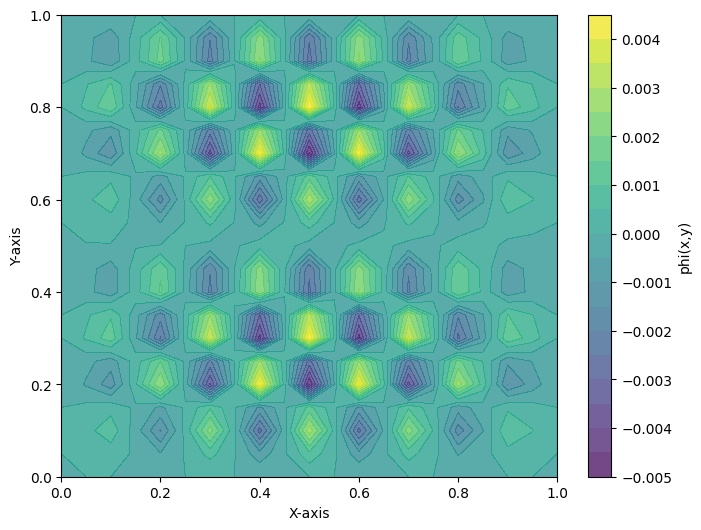

In [103]:
# try actually solving the problem here

# aluminum plate material properties
E = 70e9; nu = 0.3; thick = 0.005
D = E * thick**3 / 12.0 / (1 - nu**2)
# D = 1

# choose loading type (first just uniaxial loading in x-direction)
Nxx, Nxy, Nyy = (1e3, 0, 0)
# Nxx, Nxy, Nyy = (0, 1e2, 0)
# Nxx, Nxy, Nyy = (0, 0, 1e4)

# choose mesh size by # elements each direction
# nxe = 10; nye = 10
# nxe = 2; nye = 2
nxe = 10; nye = 10

# choose geometry of plate
# a, b = (1,1)
a, b = (1,1)

# predict the buckling load for axial case
pi = 3.14159
pred_buckling_load = pi**2 * D / b**2 * 4.0 
sigma = 0.25 * pred_buckling_load
print(f"{pred_buckling_load=}")

# try and solve the FEM buckling problem
lam, phi = solve_fem_buckling(D, a, b, Nxx, Nxy, Nyy, nxe, nye, sigma=sigma)
imin = np.argmin(lam)
lam_min = lam[imin]
print(f"{lam_min=}")
phi_min = phi[imin]
num_eig = lam.shape[0]
print(f"{num_eig=}")
plot_eigenvec(a, b, nxe, nye, phi_min)

